In [2]:
import numpy as np
import torch

from keyrover import *

In [11]:
x = np.linspace(0, 255, 200)
y = np.linspace(0, 255, 200)
xx, yy = np.meshgrid(x, y)
ones = np.ones(xx.shape)
coordinates = np.stack((xx, yy, ones), axis=-1)

p1 = np.array([0, 0])
p2 = np.array([255, 0])
p3 = np.array([255, 255])
p4 = np.array([0, 255])

In [18]:
x1, y1 = p1
x2, y2 = p2
x3, y3 = p3
x4, y4 = p4

M = np.array([[x1, x2, x3],
              [y1, y2, y3],
              [1, 1, 1]])

H = np.linalg.inv(M) @ np.array([x4, y4, 1])
A = M * H

print(H)

Ms = np.array([[0, 255, 255],
               [0, 0, 255],
               [1, 1, 1]])

Hs = np.linalg.inv(Ms) @ np.array([0, 255, 1])
B = Ms * Hs

C = B @ np.linalg.inv(A)
C

[          1          -1           1]


array([[          1, -1.3878e-17,           0],
       [          0,           1,           0],
       [          0,           0,           1]])

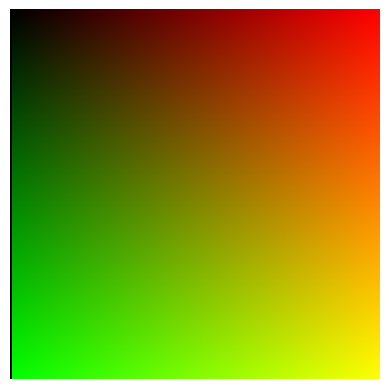

In [16]:
result = np.einsum('ij, xyj -> xyi', C, coordinates)
result = result / result[:, :, -1][:, :, None]  # dehomogenization
result[result.max(axis=2) > 255] = 0
result[result.min(axis=2) < 0] = 0
imshow(result)

In [7]:
x = np.linspace(0, 255, 640)
y = np.linspace(0, 255, 480)
xx, yy = np.meshgrid(x, y)
ones = np.ones(xx.shape)

coordinates = np.stack((xx, yy, ones), axis=-1)
coordinates = torch.tensor(coordinates, requires_grad=True, dtype=torch.float)

p1 = torch.tensor([0, 0], requires_grad=True, dtype=torch.float)
p2 = torch.tensor([255, 0], requires_grad=True, dtype=torch.float)
p3 = torch.tensor([255, 255], requires_grad=True, dtype=torch.float)
p4 = torch.tensor([0, 255], requires_grad=True, dtype=torch.float)

In [8]:
x1, y1 = p1
x2, y2 = p2
x3, y3 = p3
x4, y4 = p4

M = torch.tensor([[x1, x2, x3],
                  [y1, y2, y3],
                  [1, 1, 1]], dtype=torch.float)
X = torch.tensor([x4, y4, 1], dtype=torch.float)

M_inv = torch.inverse(M)

H = M_inv @ X
A = M * H
A_inv = torch.inverse(A)

C = torch.tensor(B, dtype=torch.float) @ A_inv
C

tensor([[1.0000e+00, 5.9139e-08, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]])

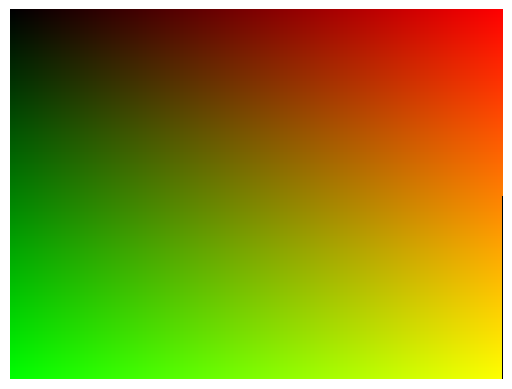

In [9]:
result = torch.einsum('ij, xyj -> xyi', C, coordinates)
result = result / result[:, :, -1][:, :, None]  # dehomogenization
result[result.max(axis=2)[0] > 255] = 0
result[result.min(axis=2)[0] < 0] = 0
imshow(result)